![Roboflow Notebooks banner](https://camo.githubusercontent.com/aec53c2b5fb6ed43d202a0ab622b58ba68a89d654fbe3abab0c0cc8bd1ff424e/68747470733a2f2f696b2e696d6167656b69742e696f2f726f626f666c6f772f6e6f7465626f6f6b732f74656d706c6174652f62616e6e657274657374322d322e706e673f696b2d73646b2d76657273696f6e3d6a6176617363726970742d312e342e33267570646174656441743d31363732393332373130313934)

# Image Classification with DINOv2

DINOv2, released by Meta Research in April 2023, implements a self-supervised method of training computer vision models.

DINOv2 was trained using 140 million images without labels. The embeddings generated by DINOv2 can be used for classification, image retrieval, segmentation, and depth estimation. With that said, Meta Research did not release heads for segmentation and depth estimation.
In this guide, we are going to build an image classifier using embeddings from DINOv2. To do so, we will:

1. Load a folder of images
2. Compute embeddings for each image
3. Save all the embeddings in a file and vector store
4. Train an SVM classifier to classify images

By the end of this notebook, we'll have a classifier trained on our dataset.

Without further ado, let's begin!

## Import Packages

First, let's import the packages we will need for this project.

In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
#import cv2
import json
import glob
from tqdm.notebook import tqdm

In [2]:
import roboflow
#import supervision as sv


In [3]:
cwd = os.getcwd()
cwd

'/workspaces/gc_quant_trading_research'

Load folder containing the trading images

In [4]:
cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd)

labels = {}

for folder in os.listdir(ROOT_DIR):
  try:
    #print(folder)
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder
            
  except:
    pass

files = labels.keys()
print(labels)

{'/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.47.04.png': 'bear', '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.59.17.png': 'bear', '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.03.png': 'bear', '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.46.01.png': 'bear', '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.06.28.png': 'bear', '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.45.50.png': 'bear', '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.27.png': 'bear', '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-13 at 14.37.05.png': 'bear', '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.09.png': 'bear', '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.13.21.png': 'bear', '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.45.p

In [5]:
list(files)

['/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.47.04.png',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.59.17.png',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.03.png',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.46.01.png',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.06.28.png',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.45.50.png',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.27.png',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-13 at 14.37.05.png',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.09.png',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.13.21.png',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.45.png',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-1

In [6]:
# prompt: get data from dictionary files

values = [labels[key] for key in files]

## Load the Model and Compute Embeddings

To train our classifier, we need:

1. The embeddings associated with each image in our dataset, and;
2. The labels associated with each image.

To calculate embeddings, we'll use DINOv2. Below, we load the smallest DINOv2 weights and define functions that will load and compute embeddings for every image in a specified list.

We store all of our vectors in a dictionary that is saved to disk so we can reference them again if needed. Note that in production environments one may opt for using another data structure such as a vector embedding database (i.e. faiss) for storing embeddings.

In [7]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

dinov2_vits14.to(device)

transform_image = T.Compose([T.ToTensor(),
                             T.Resize((70, 210)),
                             #T.CenterCrop(224),
                             T.Normalize([0.5], [0.5])])

Using cache found in /home/codespace/.cache/torch/hub/facebookresearch_dinov2_main
xFormers is not available (SwiGLU)
xFormers is not available (Attention)
xFormers is not available (Block)


In [8]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}

    with torch.no_grad():
      for i, file in enumerate(files):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

## Compute Embeddings

The code below computes the embeddings for all the images in our dataset. This step will take a few minutes for the MIT Indoor Scene Recognition dataset. There are over 10,000 images in the training set that we need to pass through DINOv2.

In [9]:
# Assuming `labels` contains the file paths and the associated label
# Generate the embeddings
from sklearn.manifold import TSNE

files = list(labels.keys())
embeddings = compute_embeddings(files)
embedding_list = list(embeddings.values())
embedding_arr = np.array(embedding_list).reshape(-1, 384)

# Generate TSNE embeddings in 3D
tsne = TSNE(n_components=2, random_state=0)
tsne_embeddings = tsne.fit_transform(embedding_arr)

In [28]:
# Convert image to data URI (Base64)
import base64
import plotly.graph_objects as go
from IPython.display import display, HTML

def image_to_data_uri(image_path):
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
    return "data:image/jpeg;base64," + encoded_image

# Cache images as data URIs
image_data_uris = {file: image_to_data_uri(file) for file in files}

# Function to display the plot and enable click events for showing images
def display_projections_2d(tsne_embeddings, labels, files, image_data_uris):
    unique_labels = np.unique(list(labels.values()))
    traces = []
    
    # Create trace for each unique label
    for label in unique_labels:
        mask = np.array([labels[file] == label for file in files])
        trace = go.Scatter(
            x=tsne_embeddings[mask, 0],
            y=tsne_embeddings[mask, 1],
            mode='markers',
            text=[(list(labels.values()))[i] for i in np.where(mask)[0]],
            customdata=[files[i] for i in np.where(mask)[0]],
            name=str(label),
            marker=dict(size=8),
            hovertemplate="<b>Label: %{text}</b><br>Path: %{customdata}<extra></extra>"
        )
        traces.append(trace)
    
    # Create the 2D scatter plot
    fig = go.Figure(data=traces)
    fig.update_layout(
        xaxis_title='X',
        yaxis_title='Y',
        width=1000,
        height=1000
    )
    
    # Convert the plot to an HTML div string and include JavaScript
    plotly_div = fig.to_html(full_html=False, include_plotlyjs=False, div_id="scatter-plot-2d")
    
    javascript_code = f"""
    <script>
        function displayImage(imagePath) {{
            var imageElement = document.getElementById('image-display');
            var placeholderText = document.getElementById('placeholder-text');
            var imageDataURIs = {image_data_uris};
            imageElement.src = imageDataURIs[imagePath];
            imageElement.style.display = 'block';
            placeholderText.style.display = 'none';
        }}

        // Set up event listener for Plotly chart clicks
        document.getElementById('scatter-plot-2d').on('plotly_click', function(data) {{
            var imagePath = data.points[0].customdata;
            displayImage(imagePath);
        }});
    </script>
    """
    
    # HTML structure for displaying the chart and image
    html_template = f"""
    <!DOCTYPE html>
    <html>
        <head>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            <style>
                #image-container {{
                    position: fixed;
                    top: 0;
                    left: 0;
                    width: 200px;
                    height: 200px;
                    padding: 15px;
                    border: 1px solid #ccc;
                    background-color: white;
                    z-index: 1000;
                    box-sizing: border-box;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    text-align: center;
                }}
                #image-display {{
                    width: 100%;
                    height: 100%;
                    object-fit: contain;
                }}
            </style>
        </head>
        <body>
            {plotly_div}
            <div id="image-container">
                <img id="image-display" src="" alt="Selected image" style="display: none;" />
                <p id="placeholder-text">Click on a data entry to display an image</p>
            </div>
            {javascript_code}
        </body>
    </html>
    """
    
    # Write the HTML template to a file
    plot_html = "2d_scatter_plot.html"
    with open(plot_html, "w") as f:
        f.write(html_template)

    # Display the HTML template
    display(HTML(html_template))





{'/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.47.04.png': '',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.59.17.png': '',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.03.png': '',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.46.01.png': '',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.06.28.png': '',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 13.45.50.png': '',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.27.png': '',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-13 at 14.37.05.png': '',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.09.png': '',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.13.21.png': '',
 '/workspaces/gc_quant_trading_research/bear/Screenshot 2024-09-14 at 14.03.45.png': '',
 '/workspaces/gc_quan
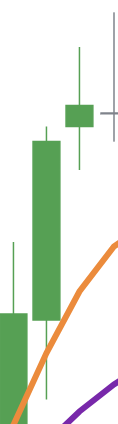
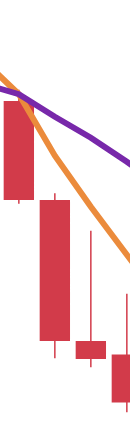
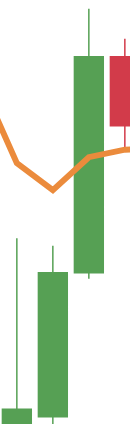
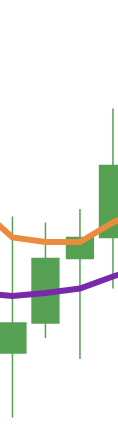
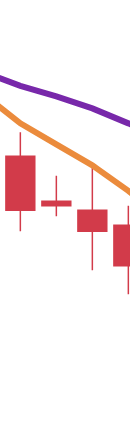
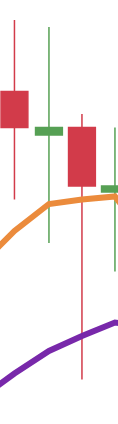
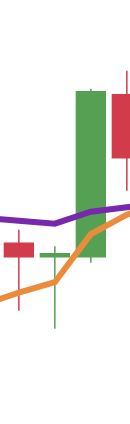
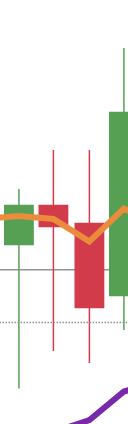
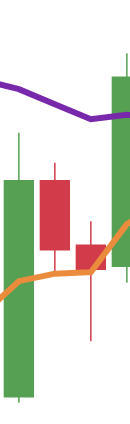
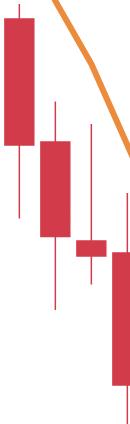
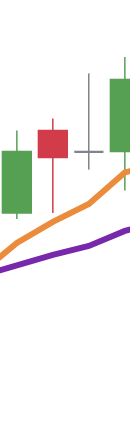
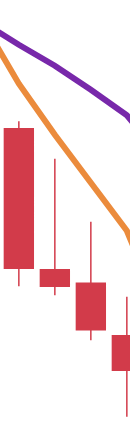
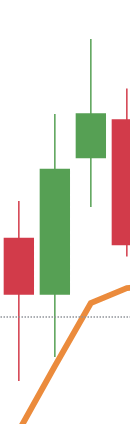
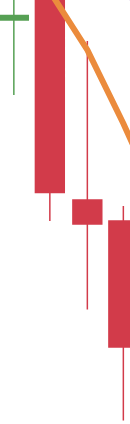
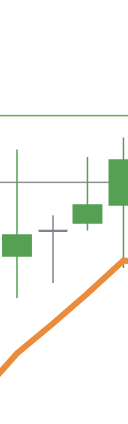
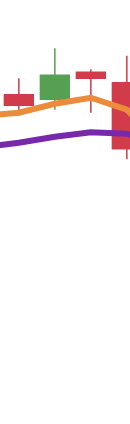
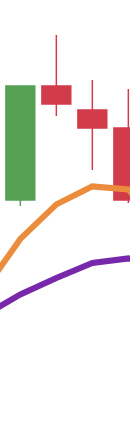
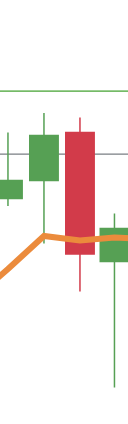
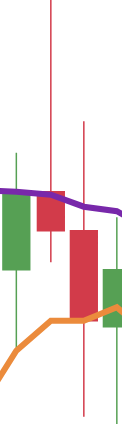
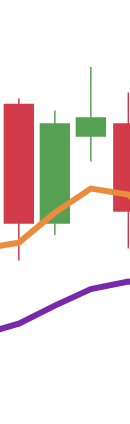
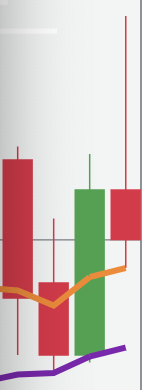
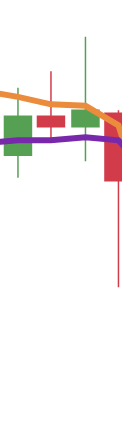
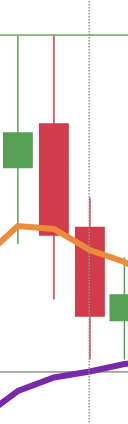
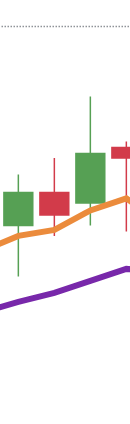
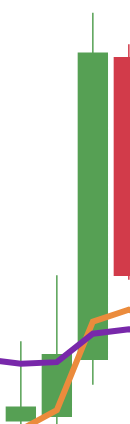
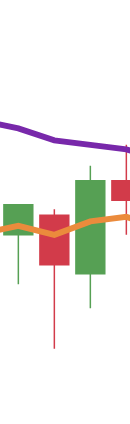
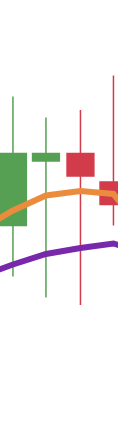
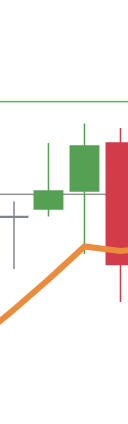
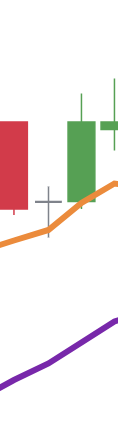
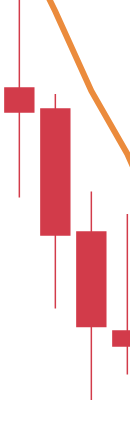
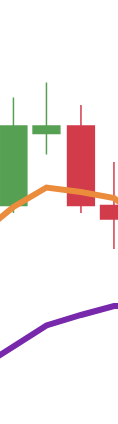
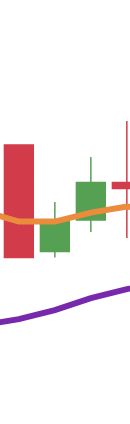
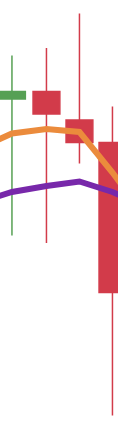
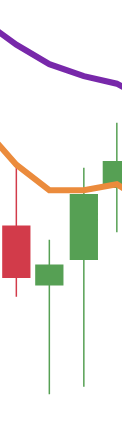
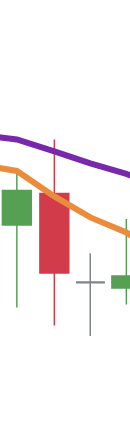
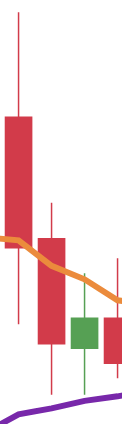
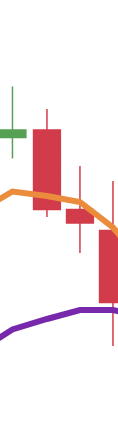
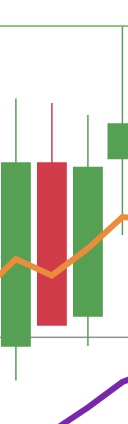
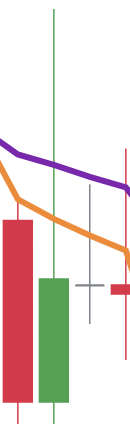
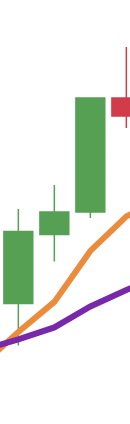
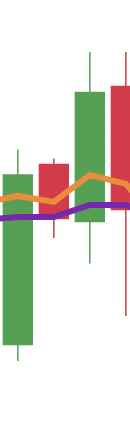
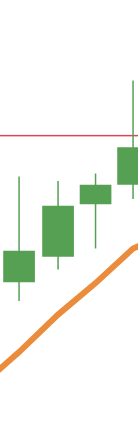
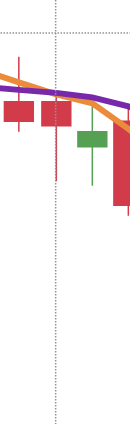
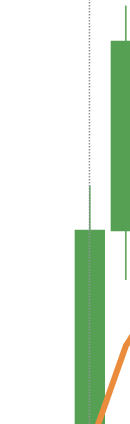
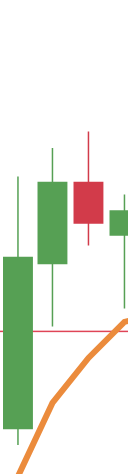
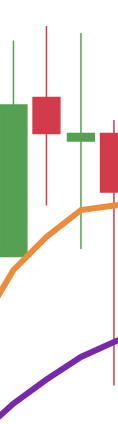
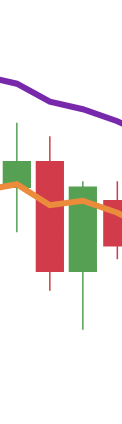
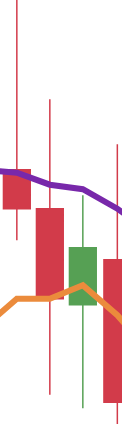
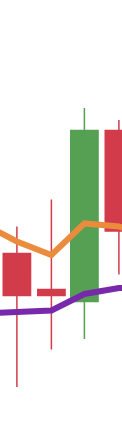
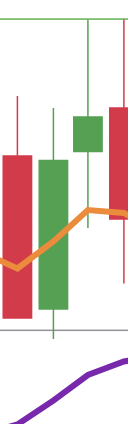
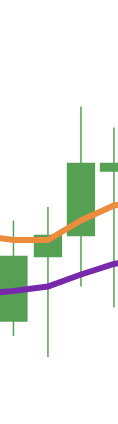
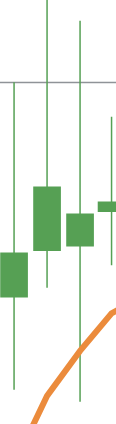
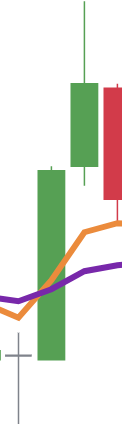
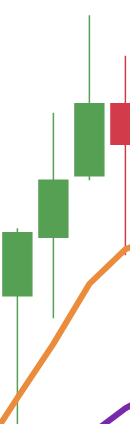
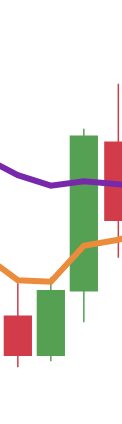
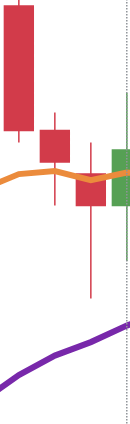
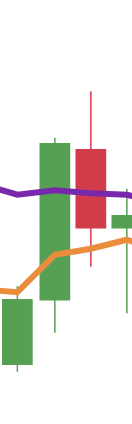
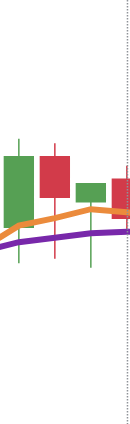
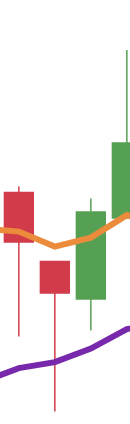
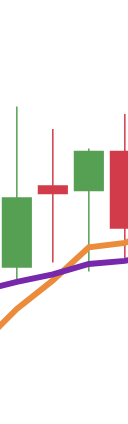
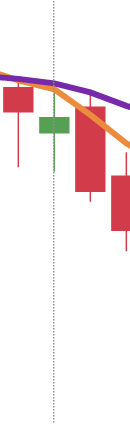
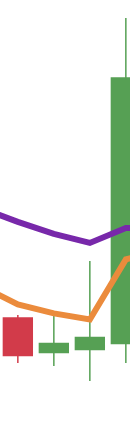
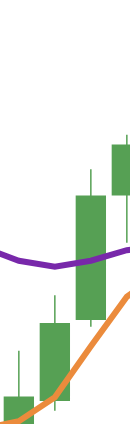
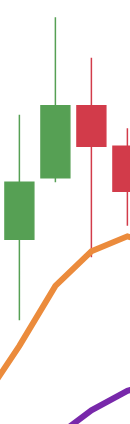
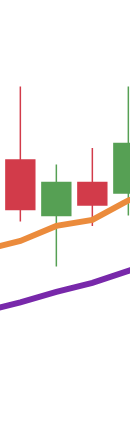
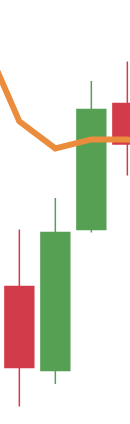
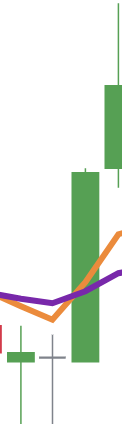
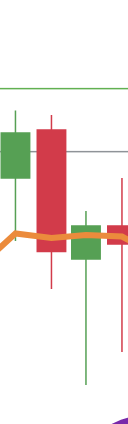
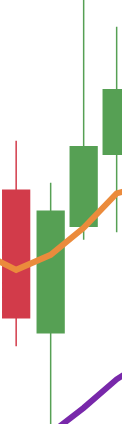
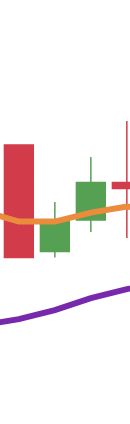
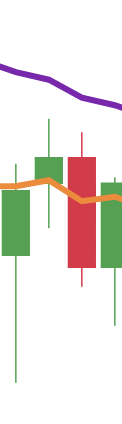
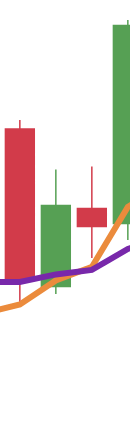
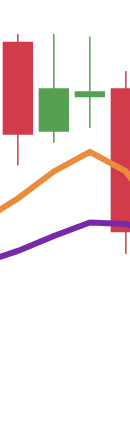
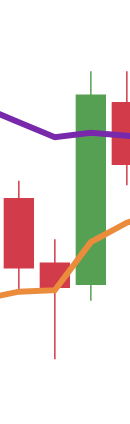
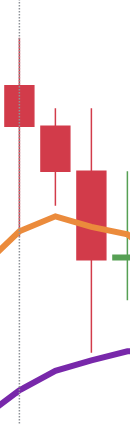
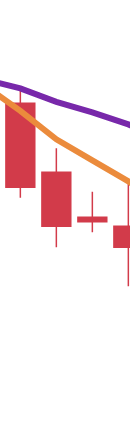
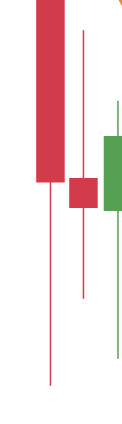
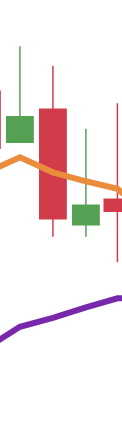
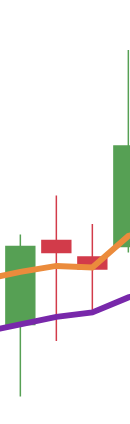
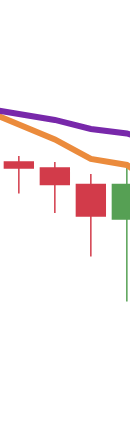
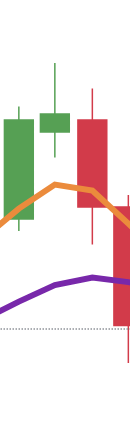
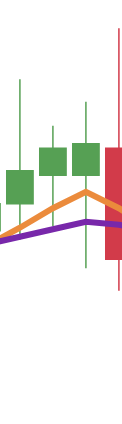
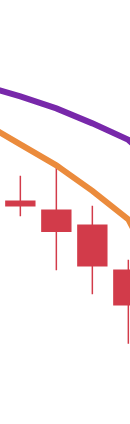
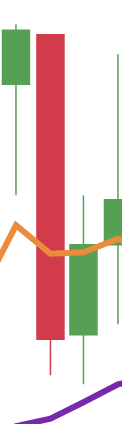
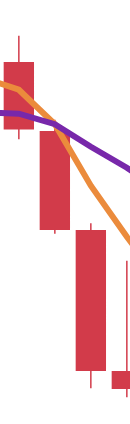
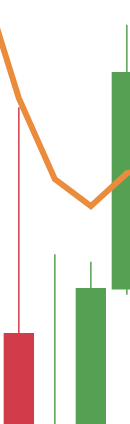
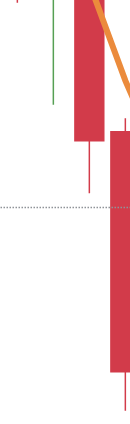
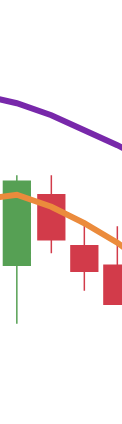
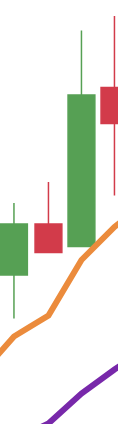
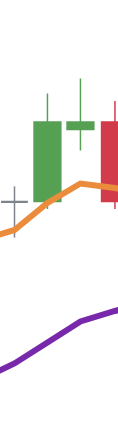
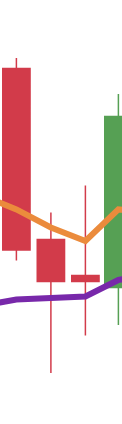
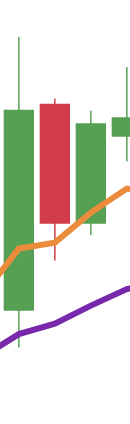
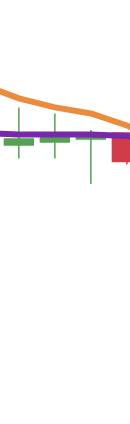
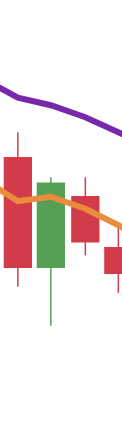
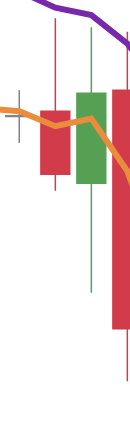
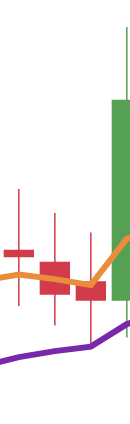
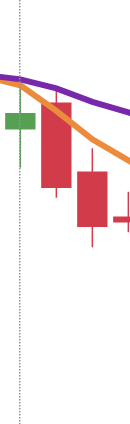
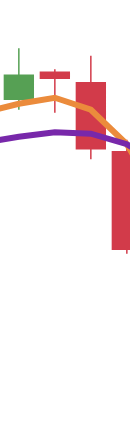
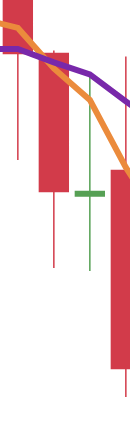
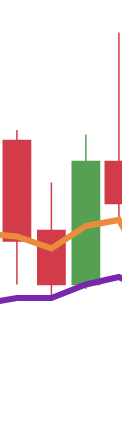
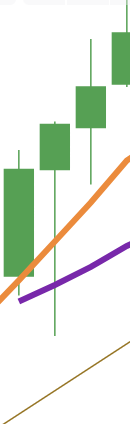
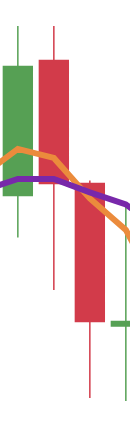
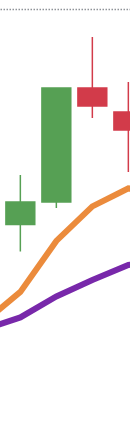
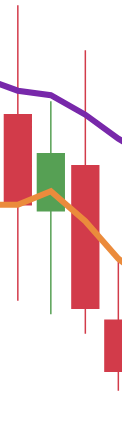
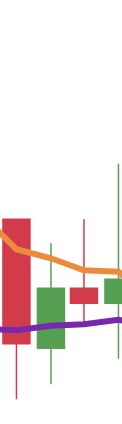
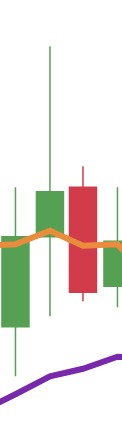
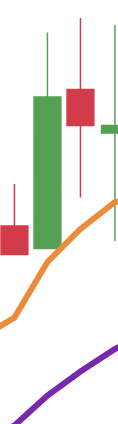
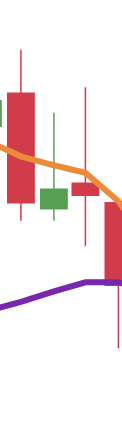
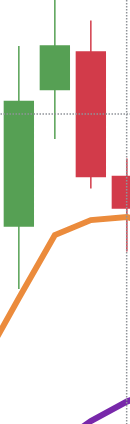
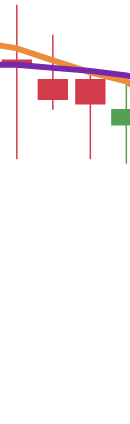
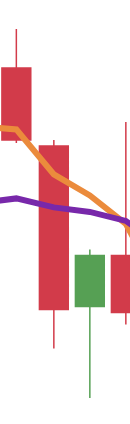
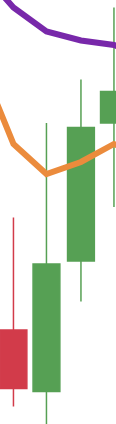
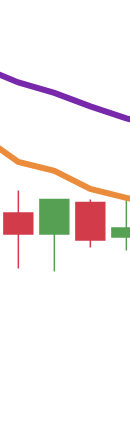
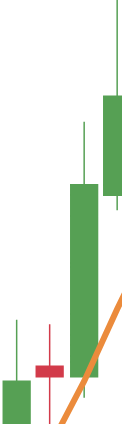
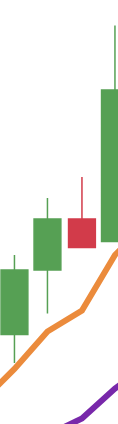
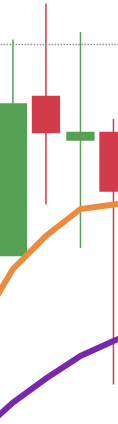
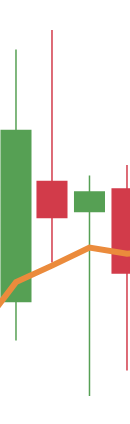
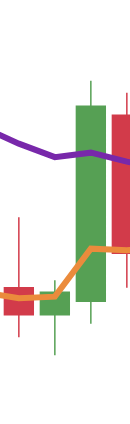
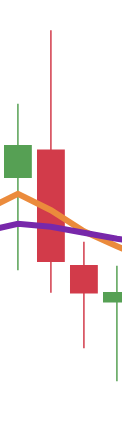
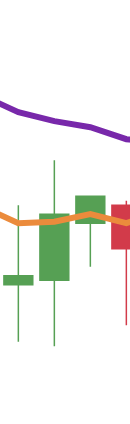
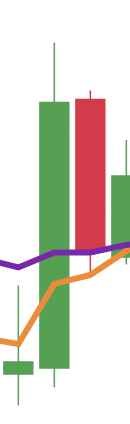
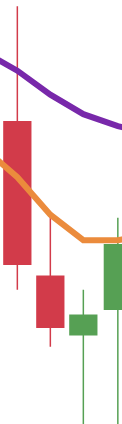
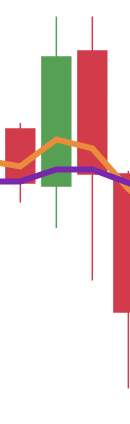
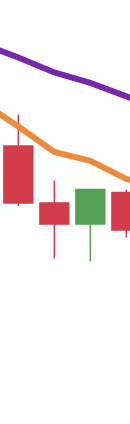
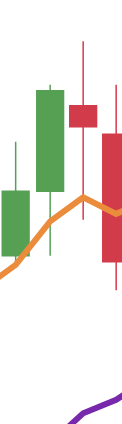
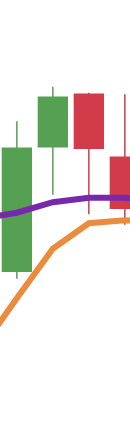
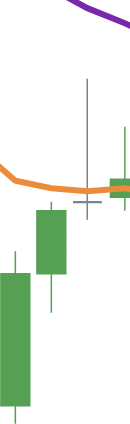
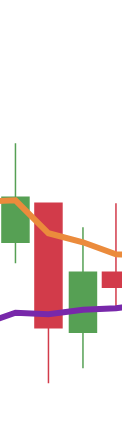
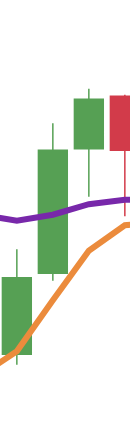
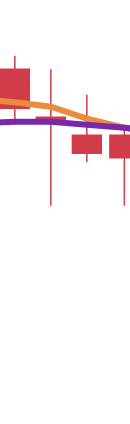
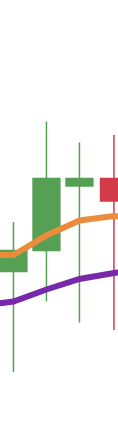
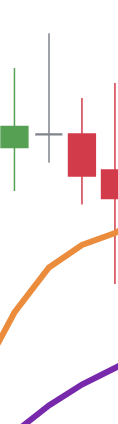
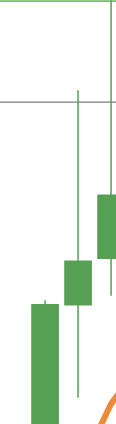
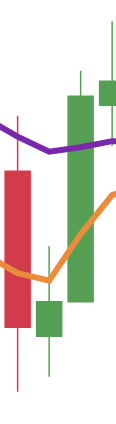
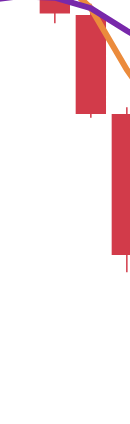
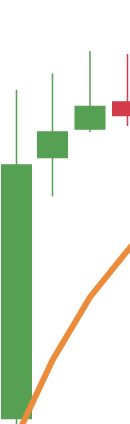
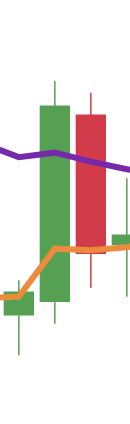
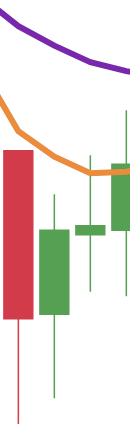
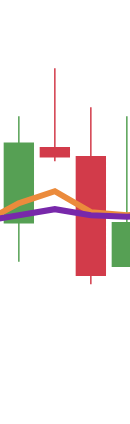
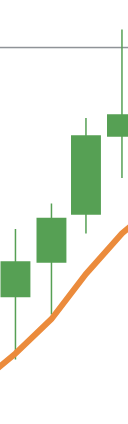
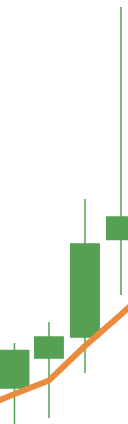
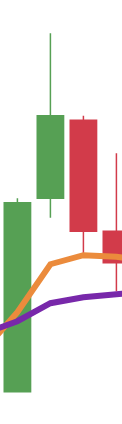
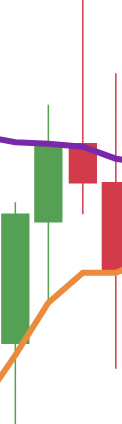
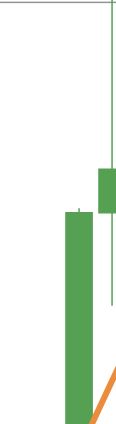
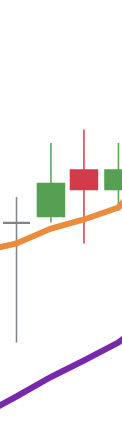
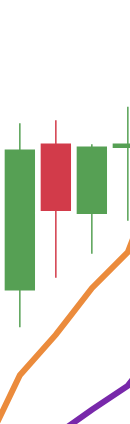
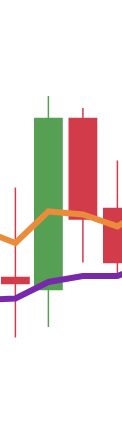
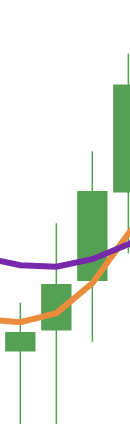
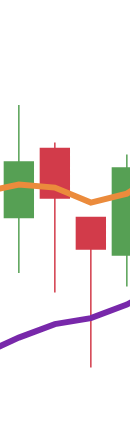
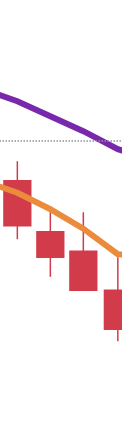
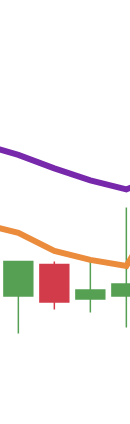
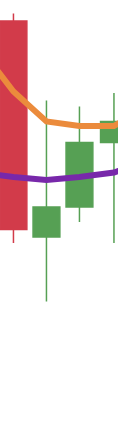
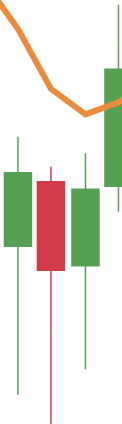
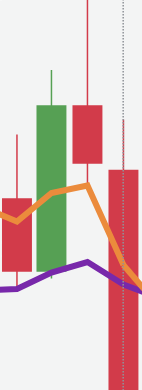
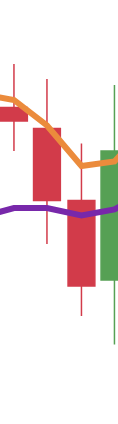
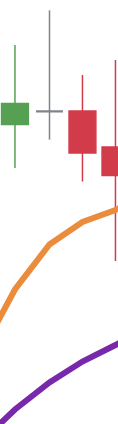
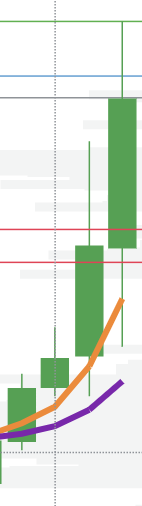
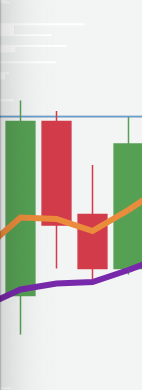
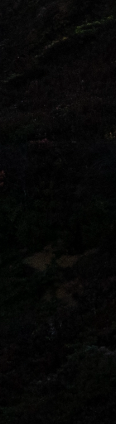
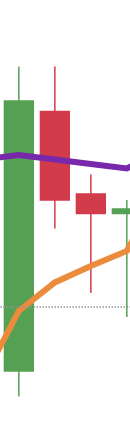
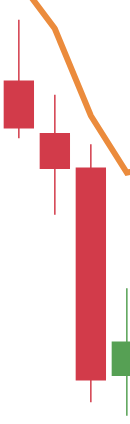
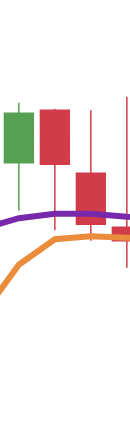
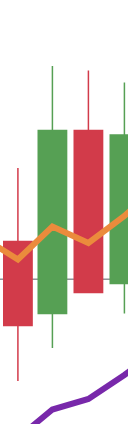
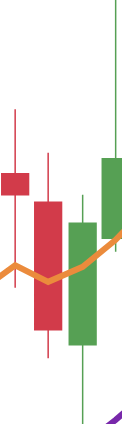
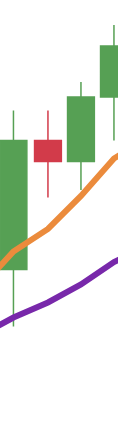
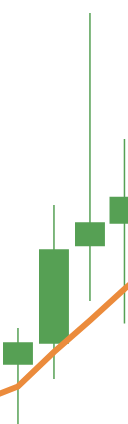
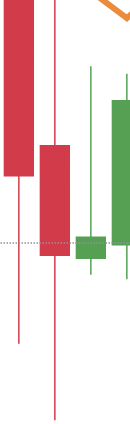
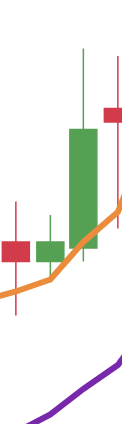
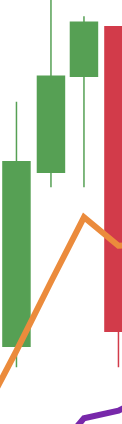
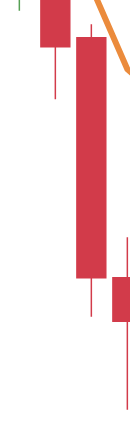
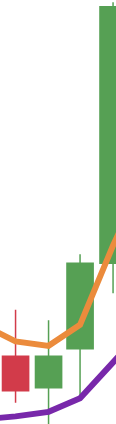
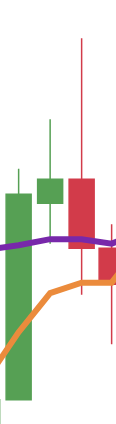
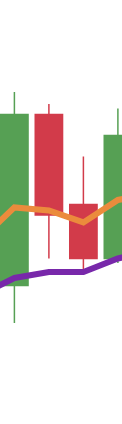
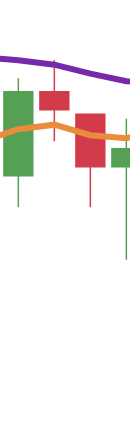
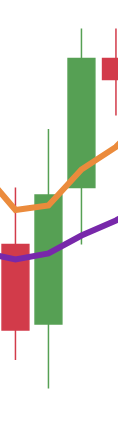
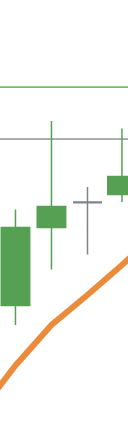
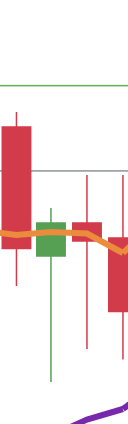
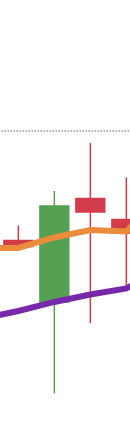
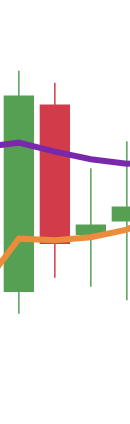
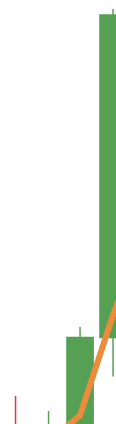
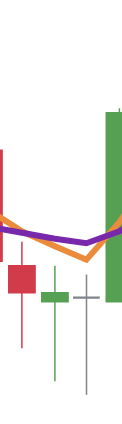
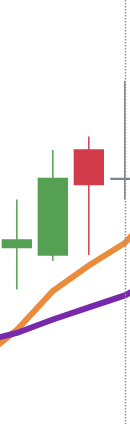
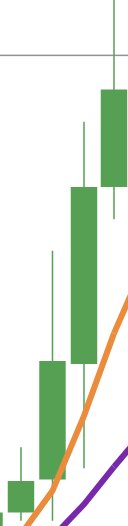
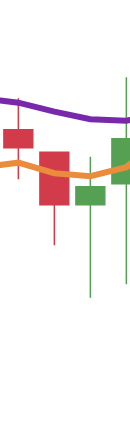
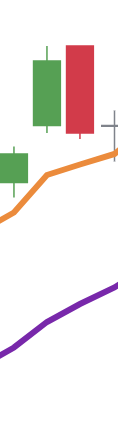
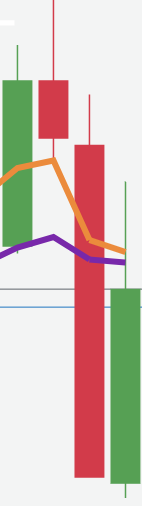
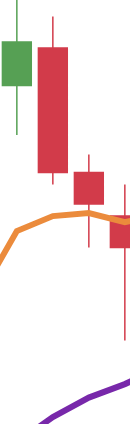
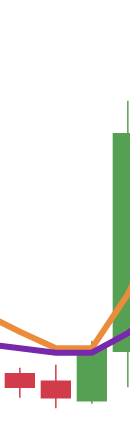
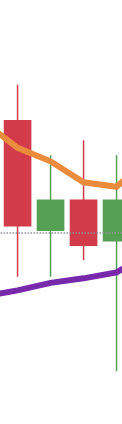
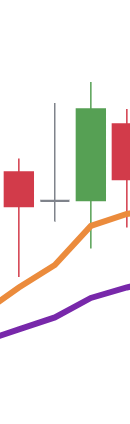
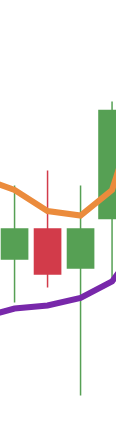
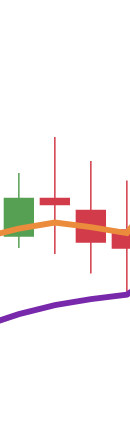
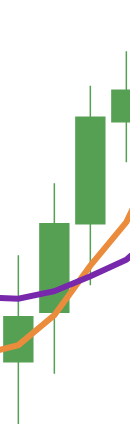
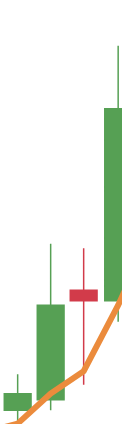
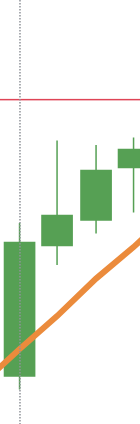
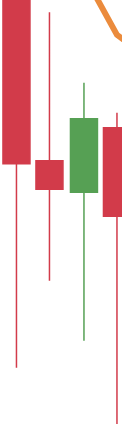
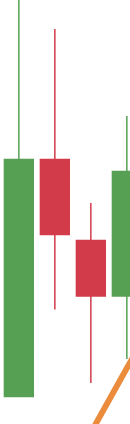
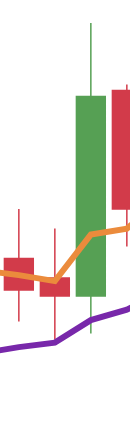
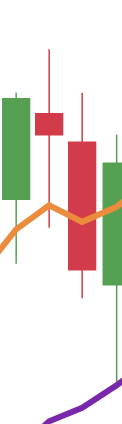
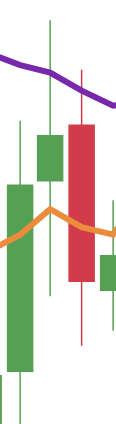
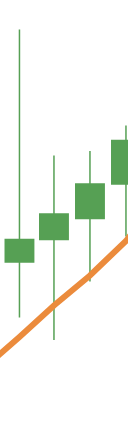
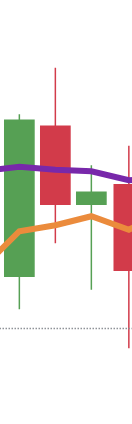
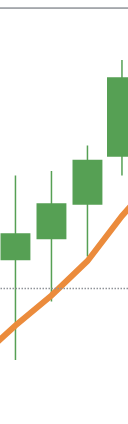
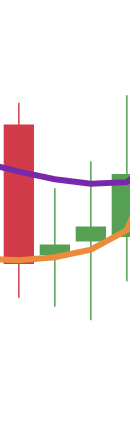
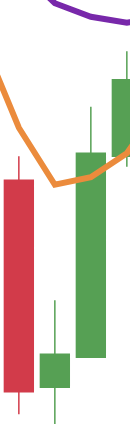
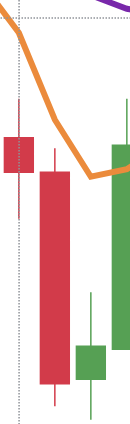
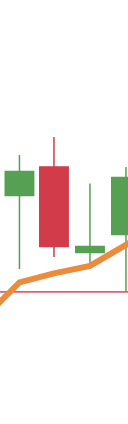
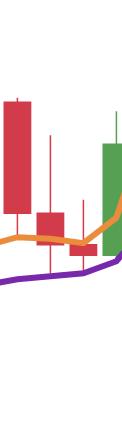
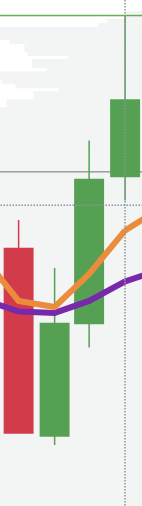
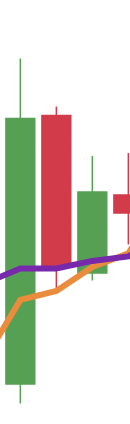
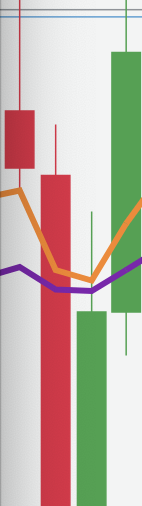
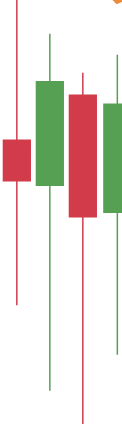
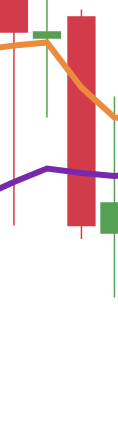
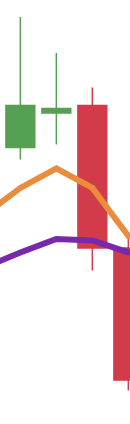
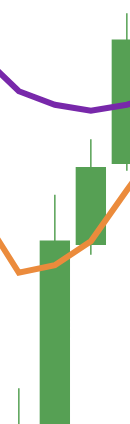
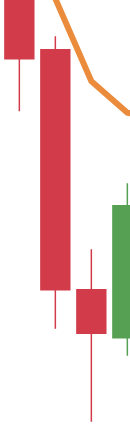
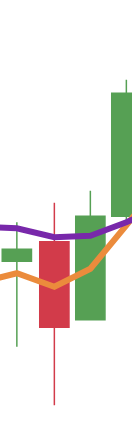
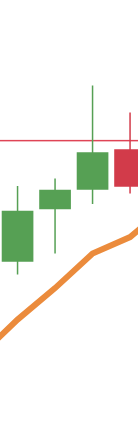
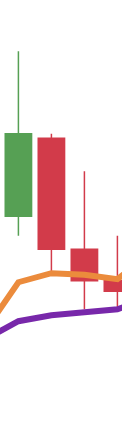
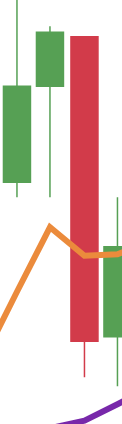
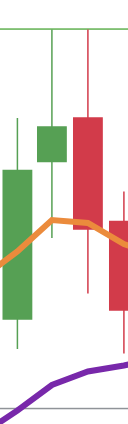
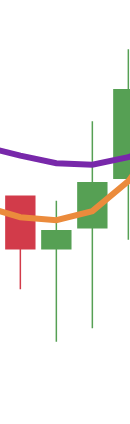
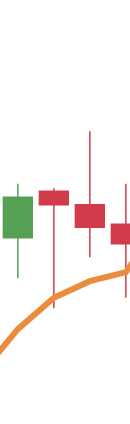
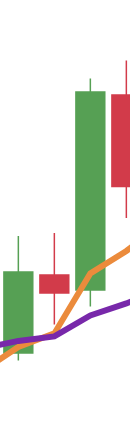
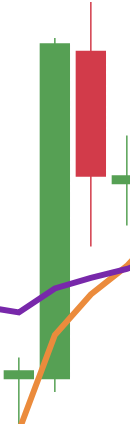
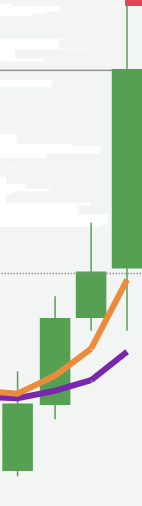
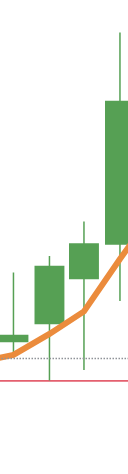
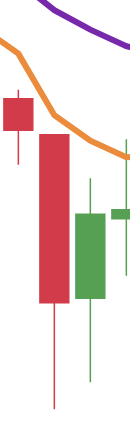
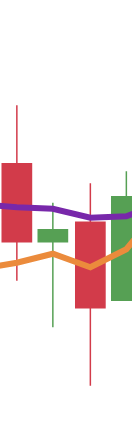
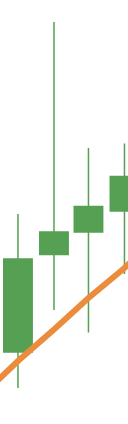
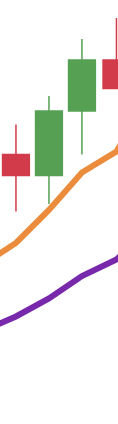
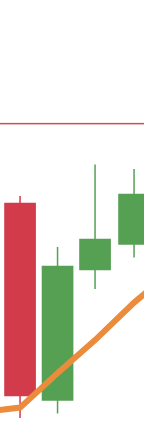
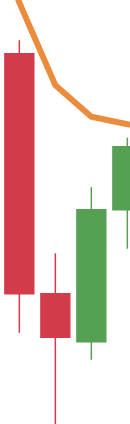
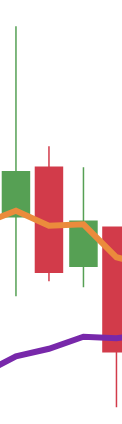
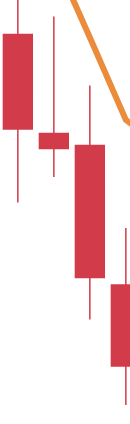
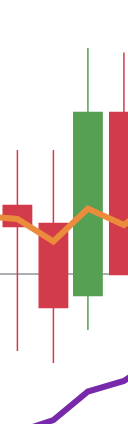
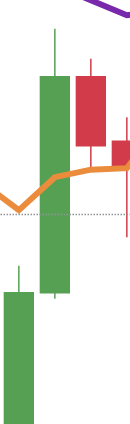
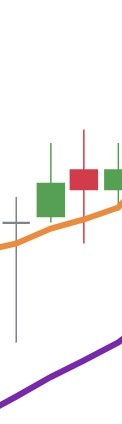
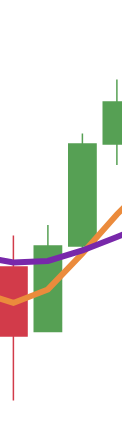
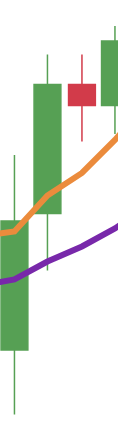
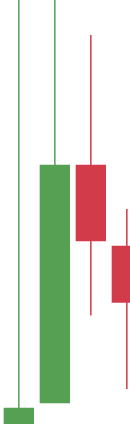
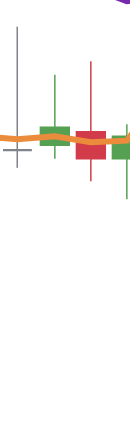
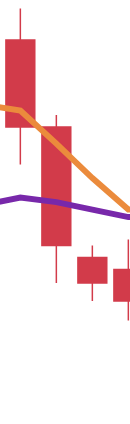
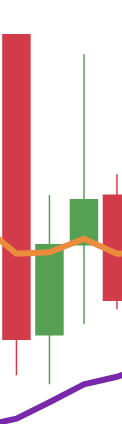
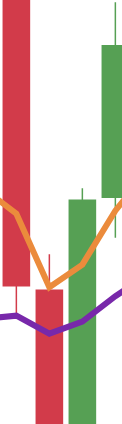
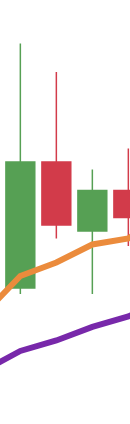
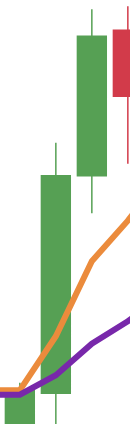
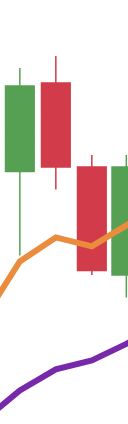

In [29]:
image_data_uris


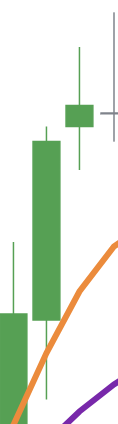
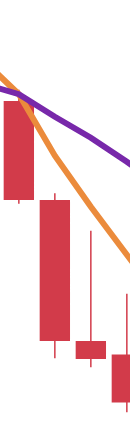
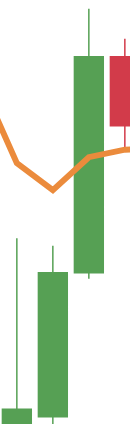
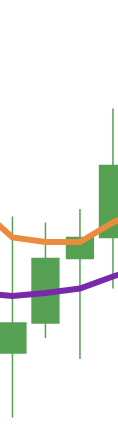
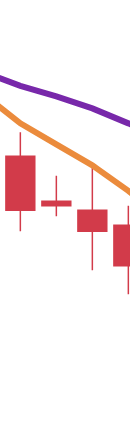
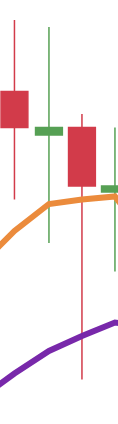
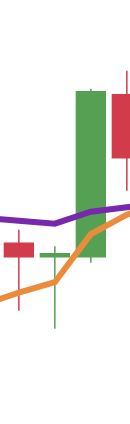
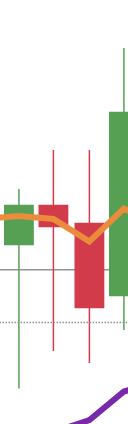
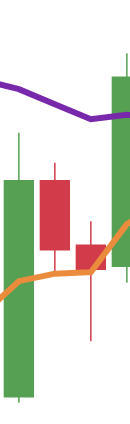
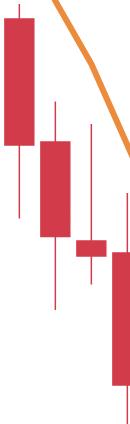
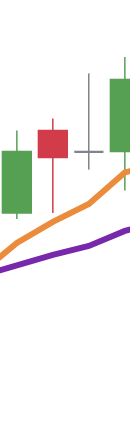
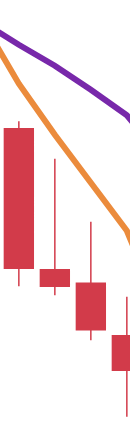
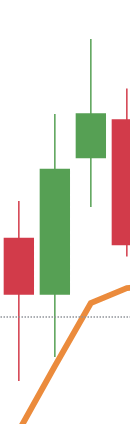
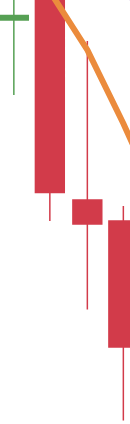
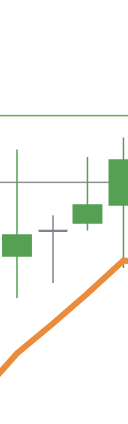
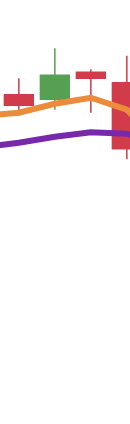
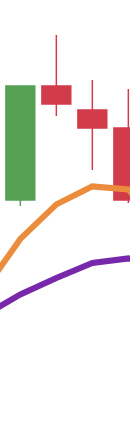
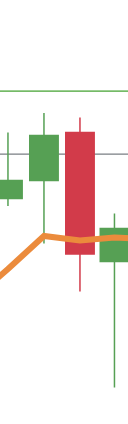
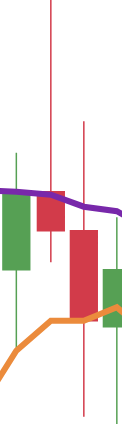
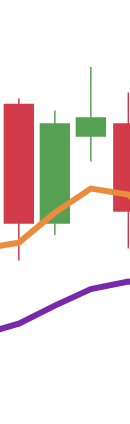
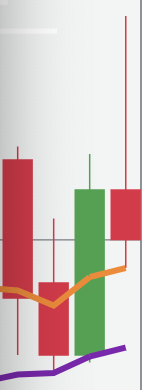
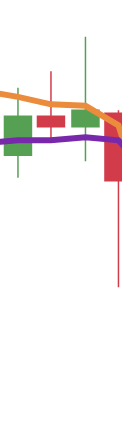
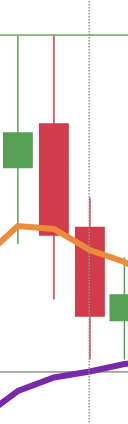
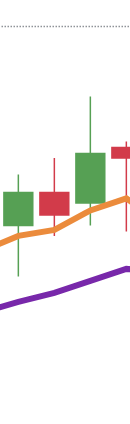
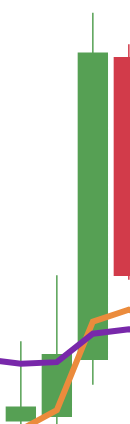
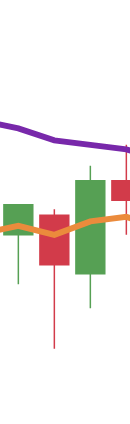
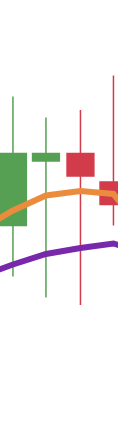
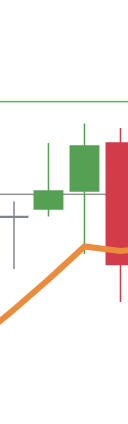
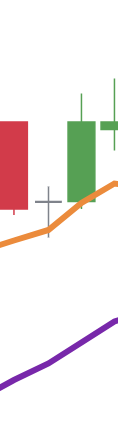
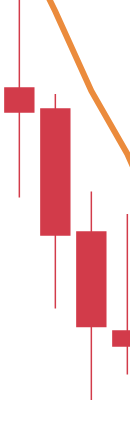
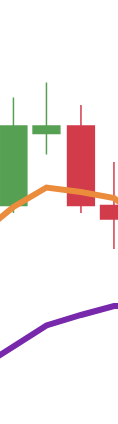
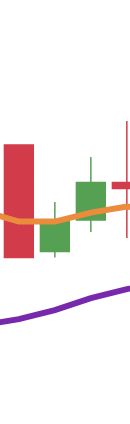
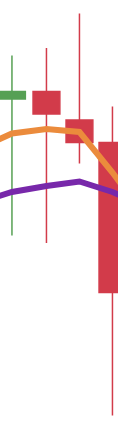
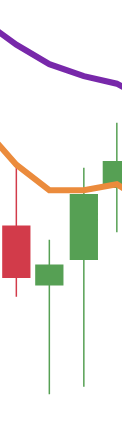
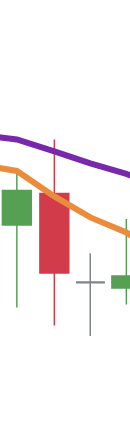
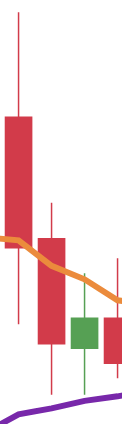
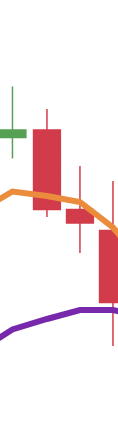
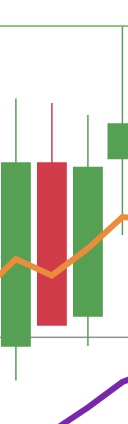
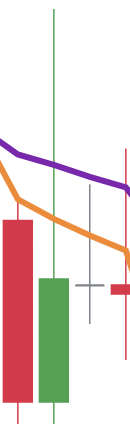
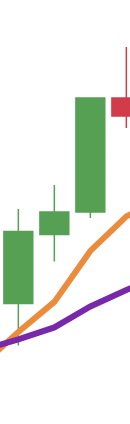
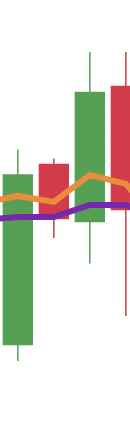
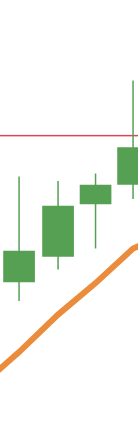
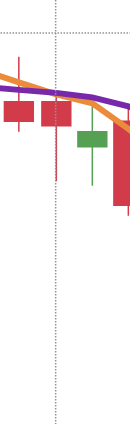
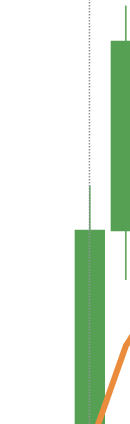
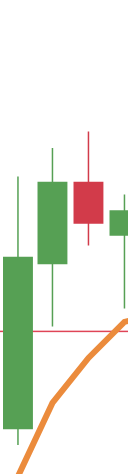
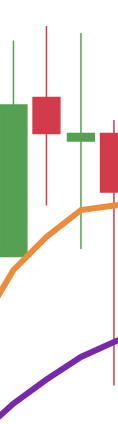
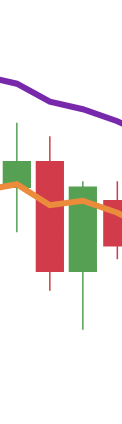
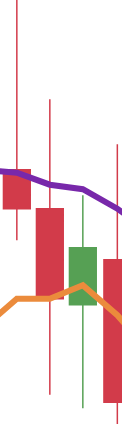
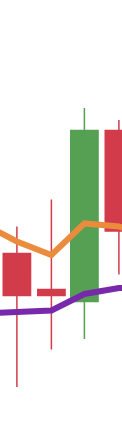
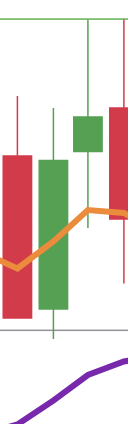
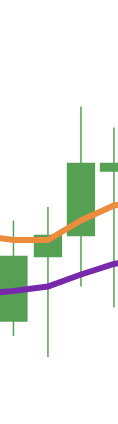
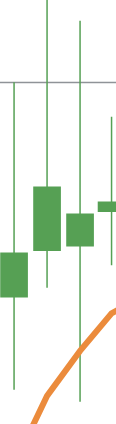
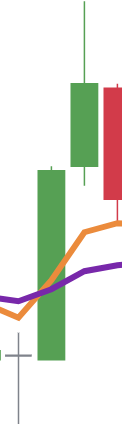
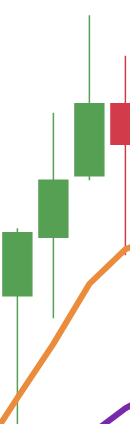
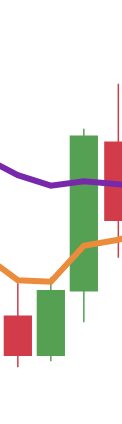
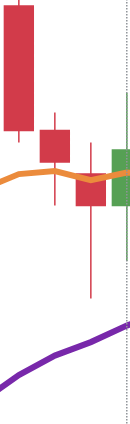
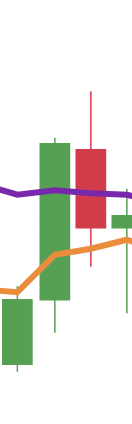
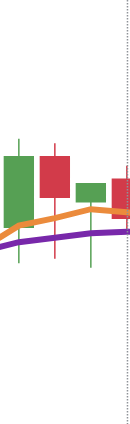
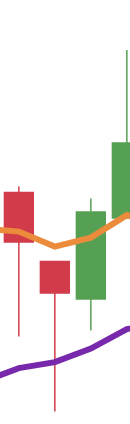
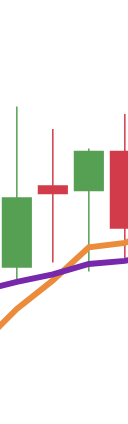
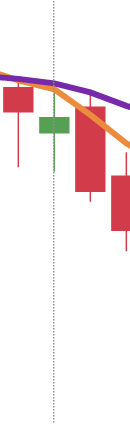
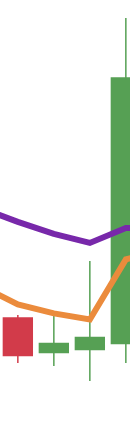
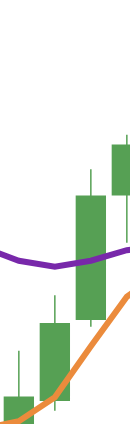
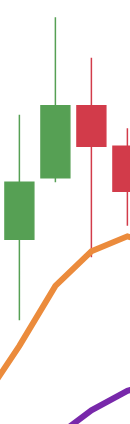
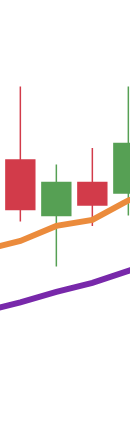
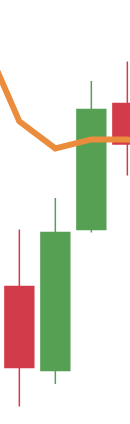
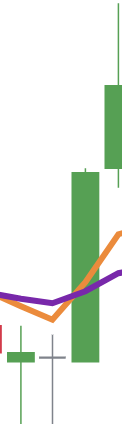
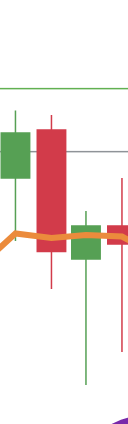
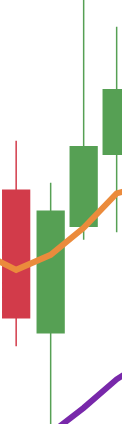
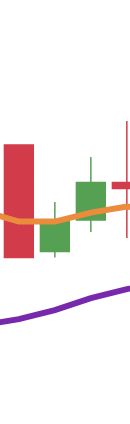
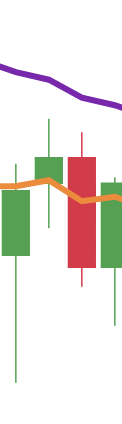
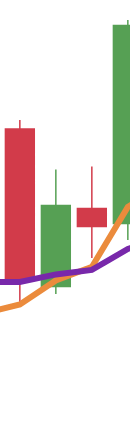
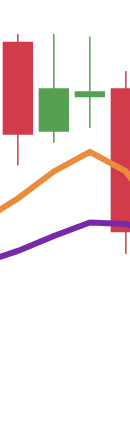
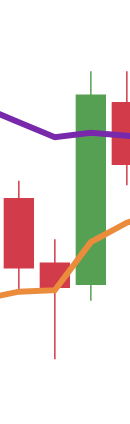
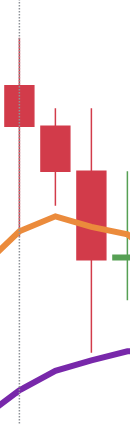
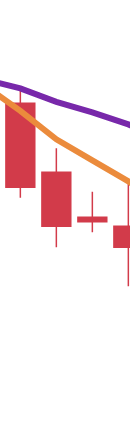
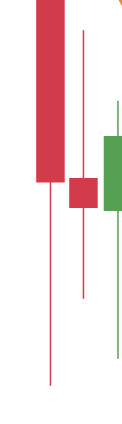
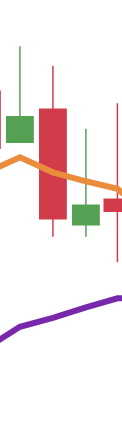
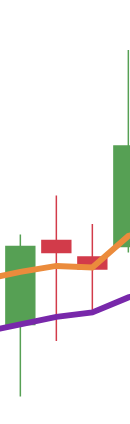
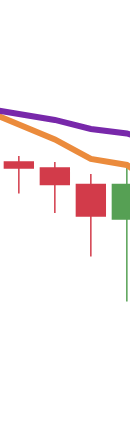
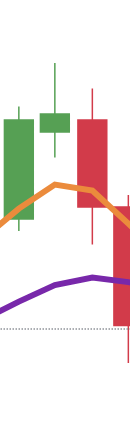
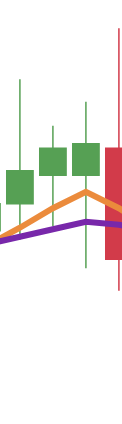
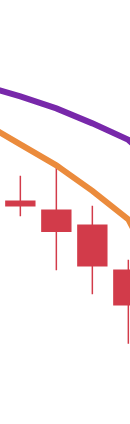
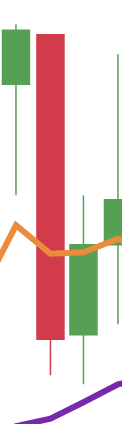
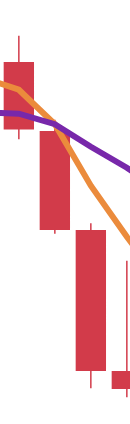
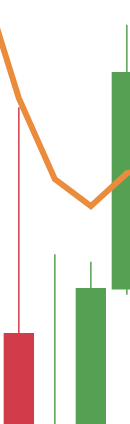
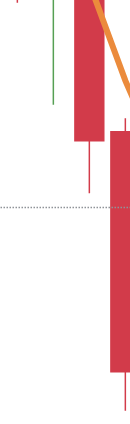
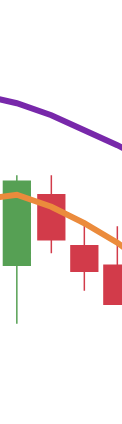
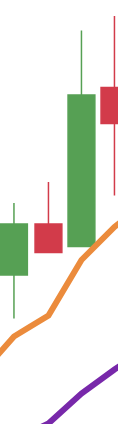
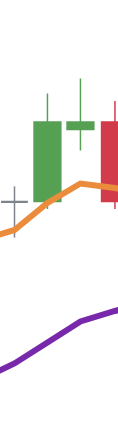
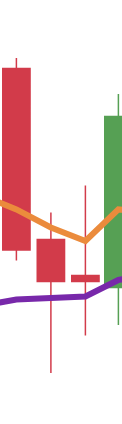
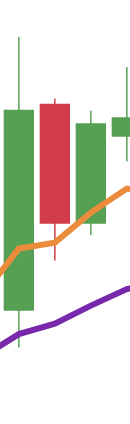
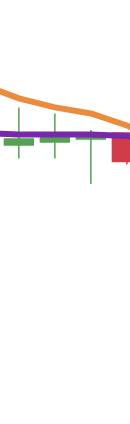
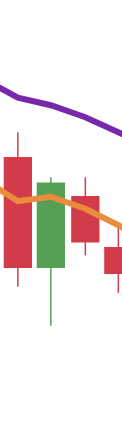
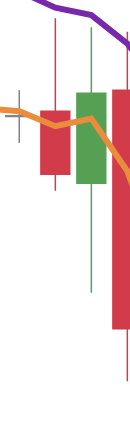
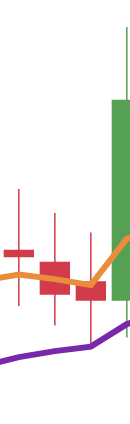
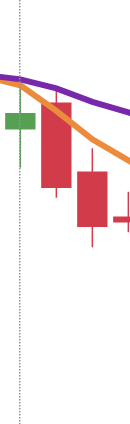
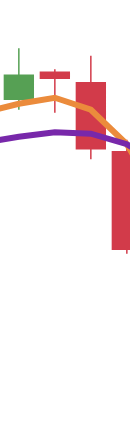
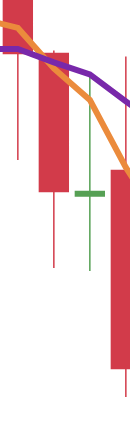
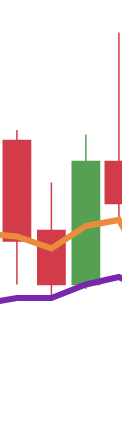
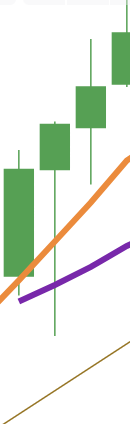
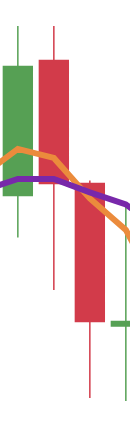
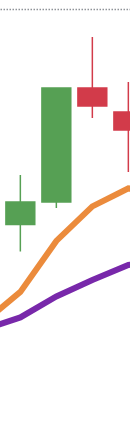
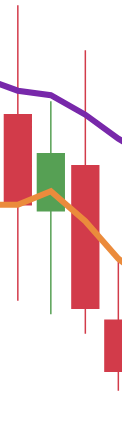
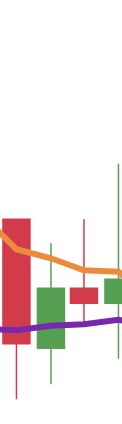
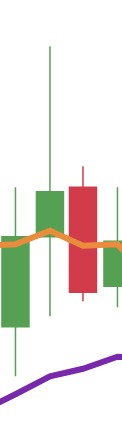
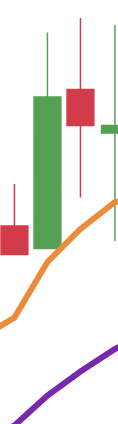
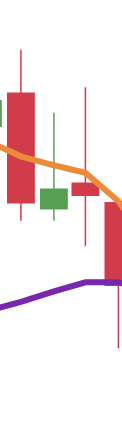
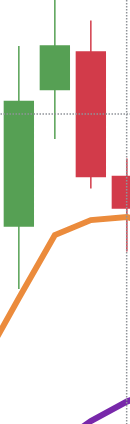
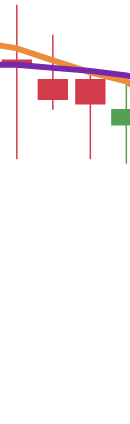
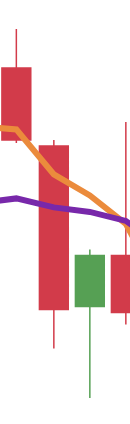
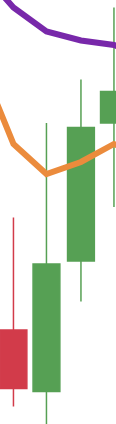
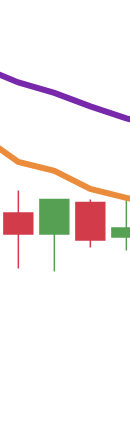
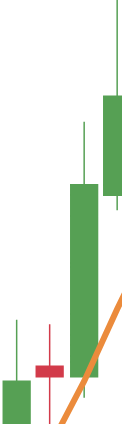
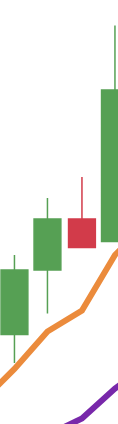
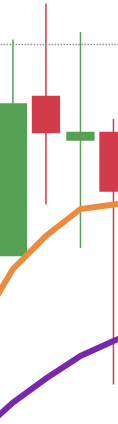
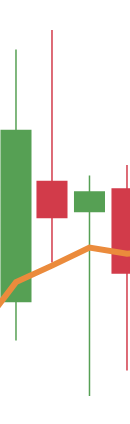
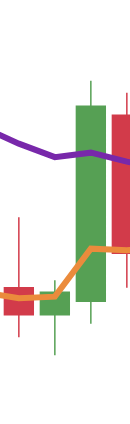
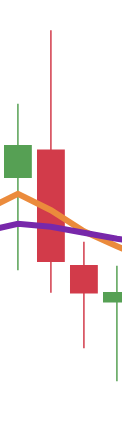
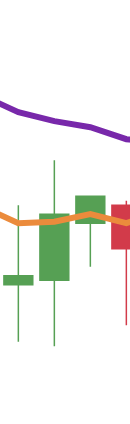
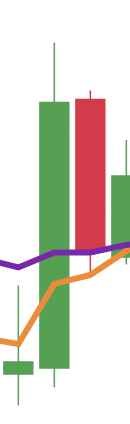
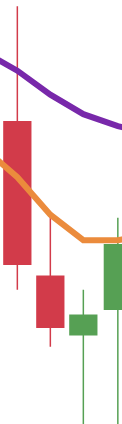
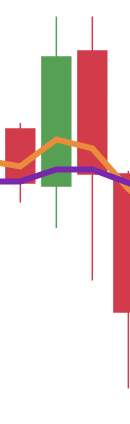
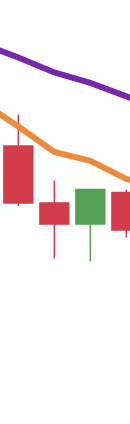
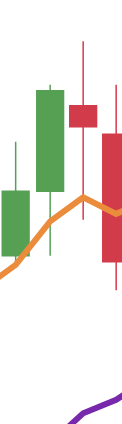
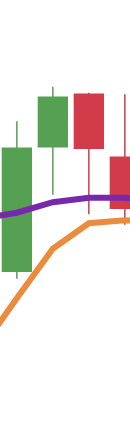
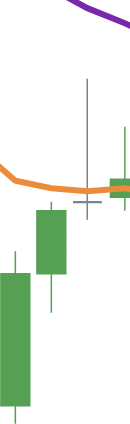
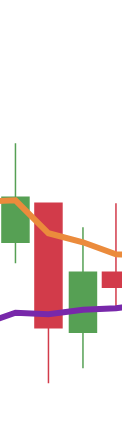
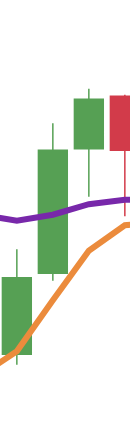
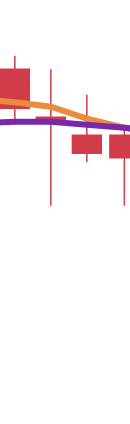
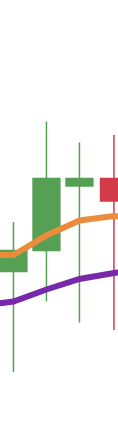
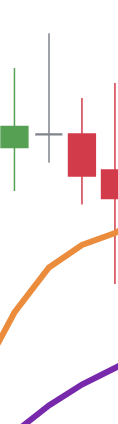
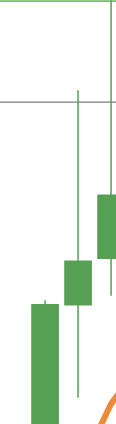
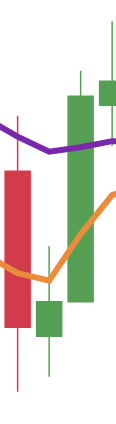
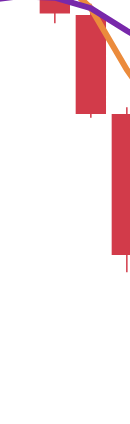
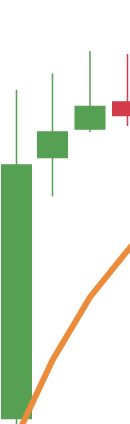
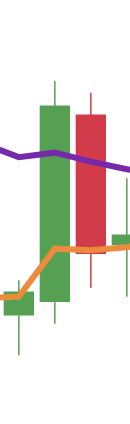
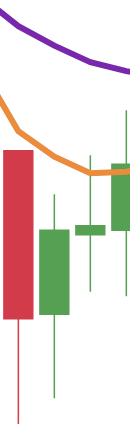
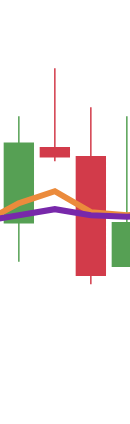
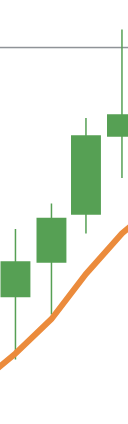
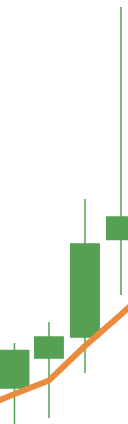
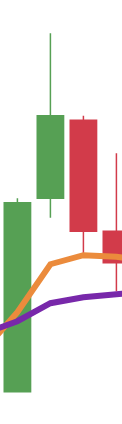
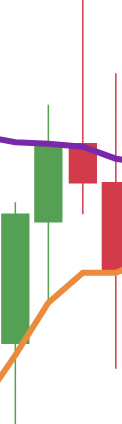
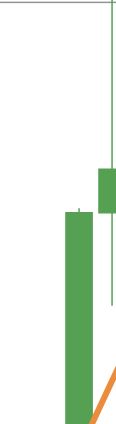
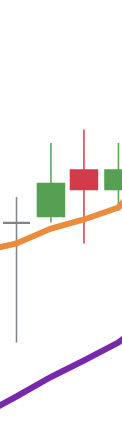
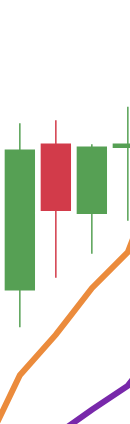
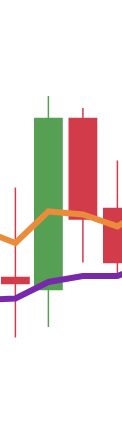
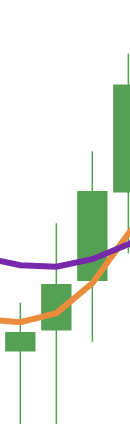
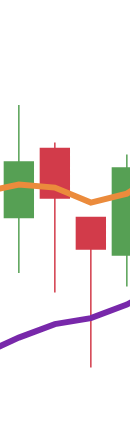
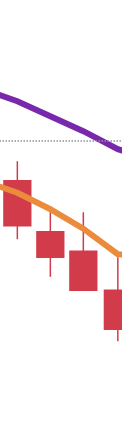
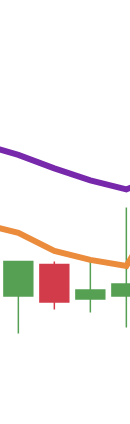
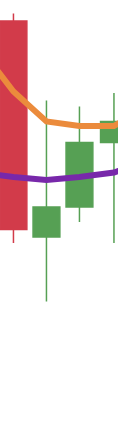
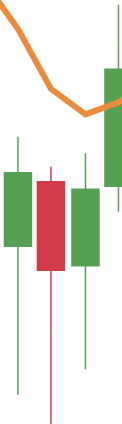
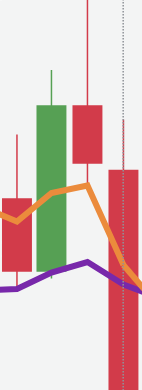
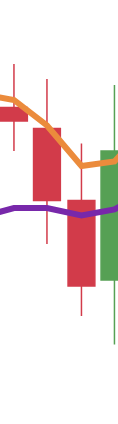
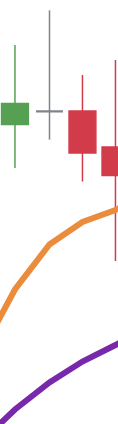
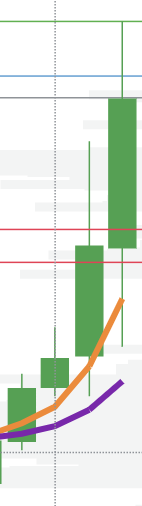
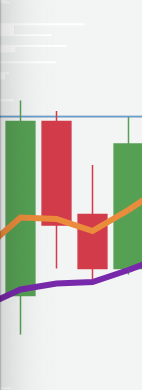
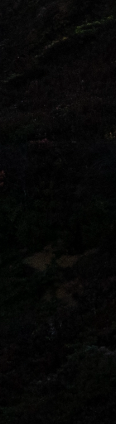
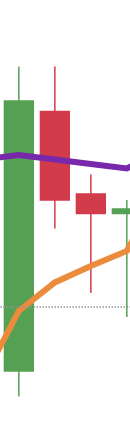
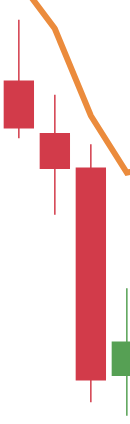
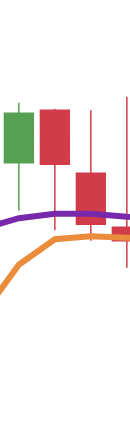
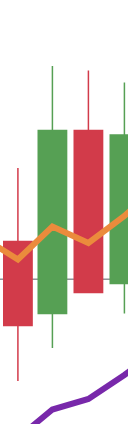
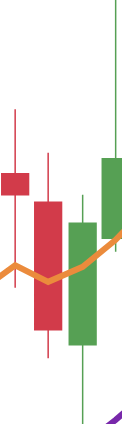
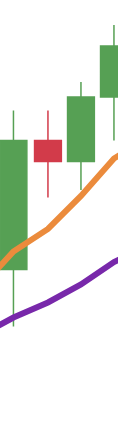
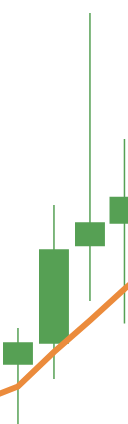
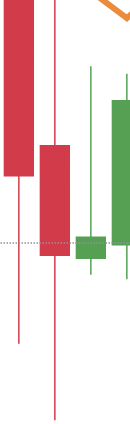
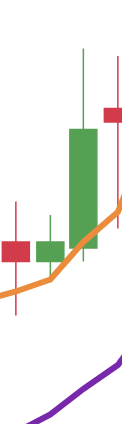
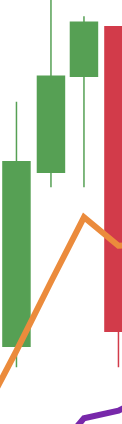
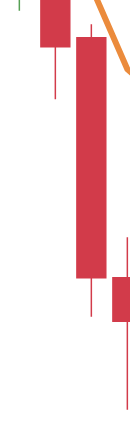
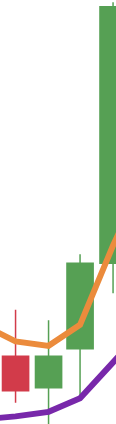
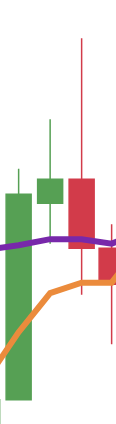
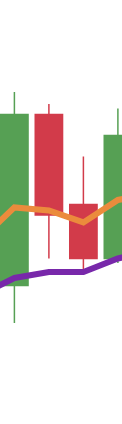
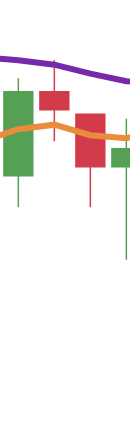
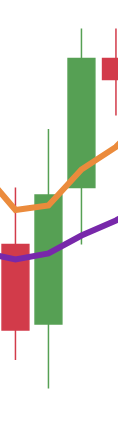
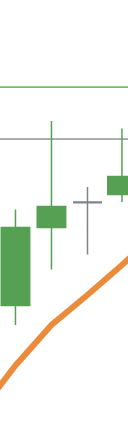
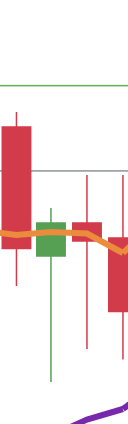
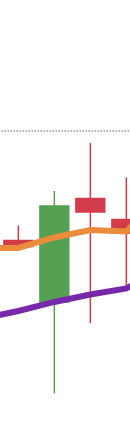
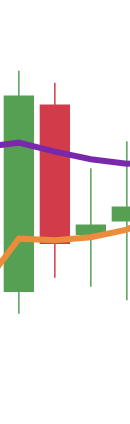
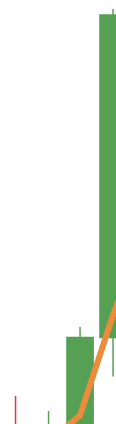
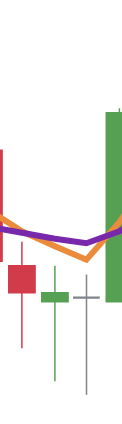
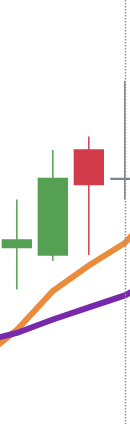
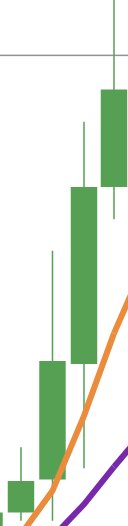
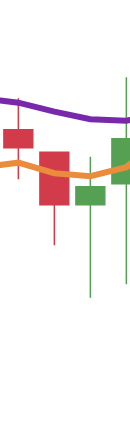
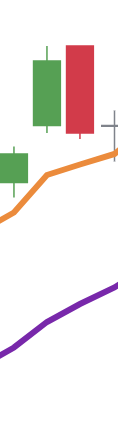
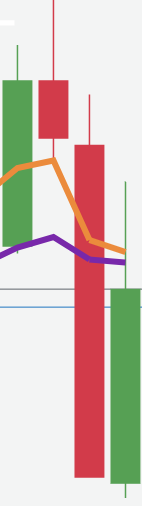
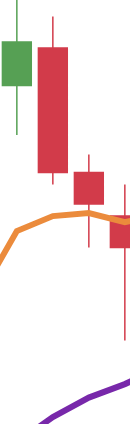
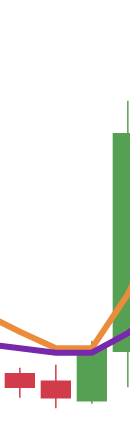
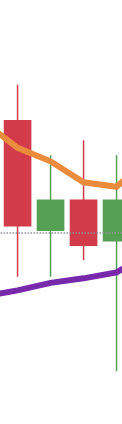
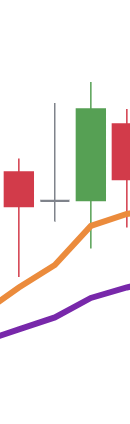
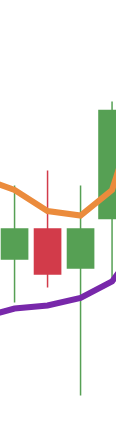
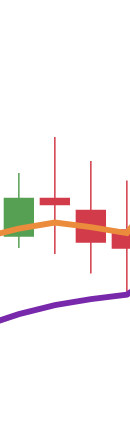
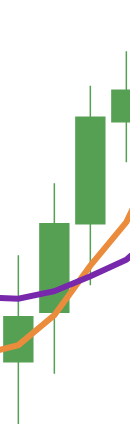
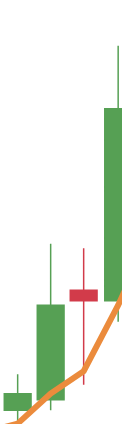
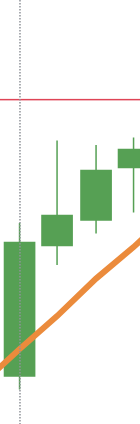
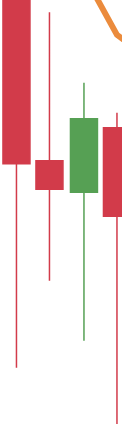
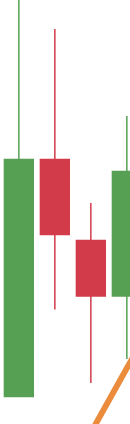
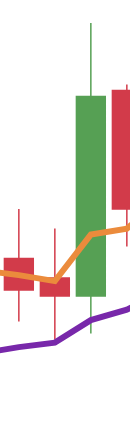
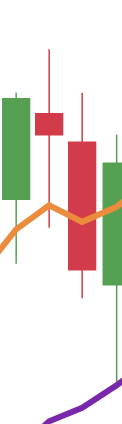
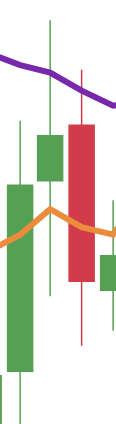
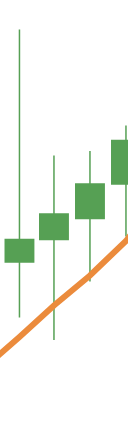
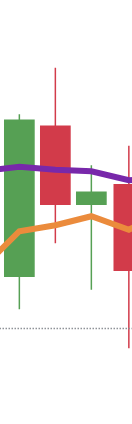
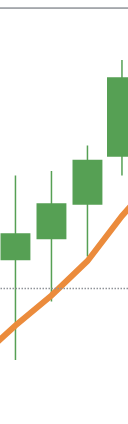
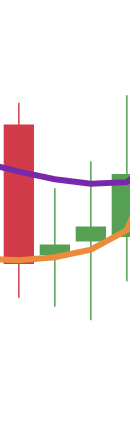
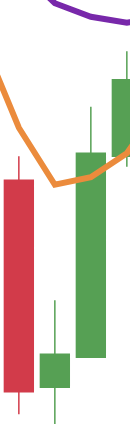
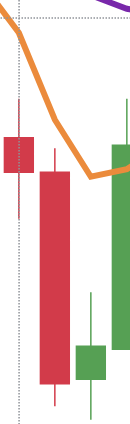
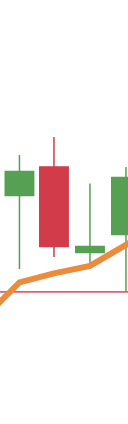
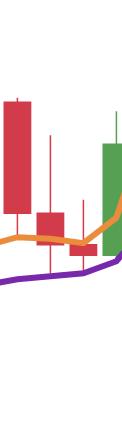
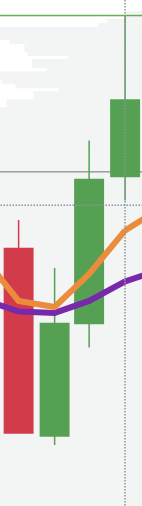
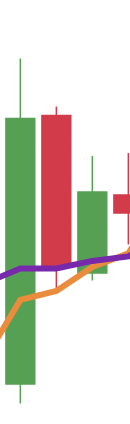
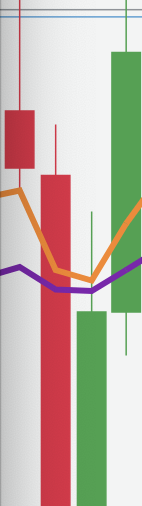
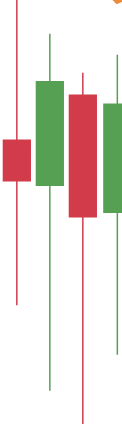
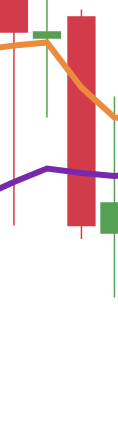
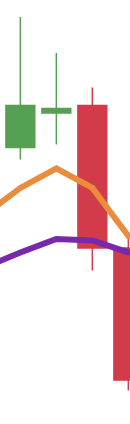
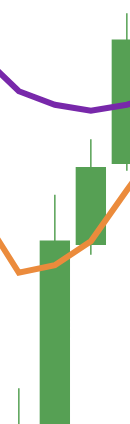
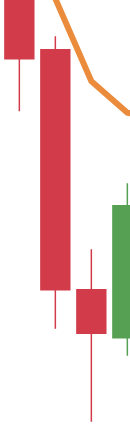
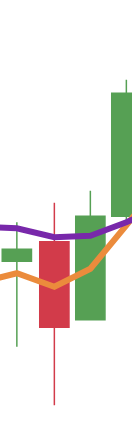
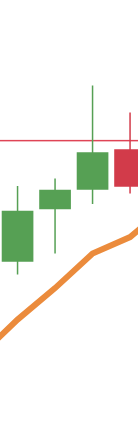
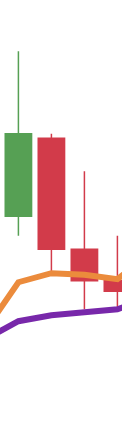
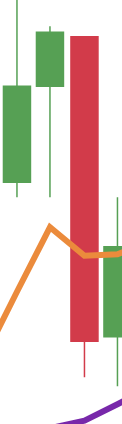
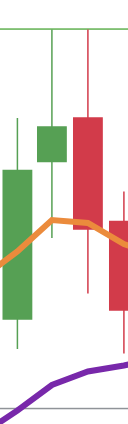
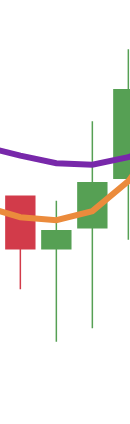
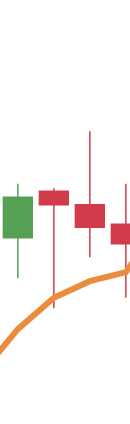
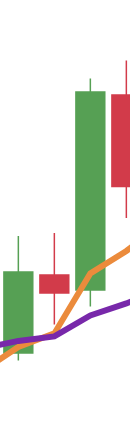
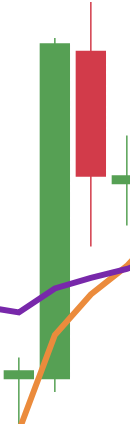
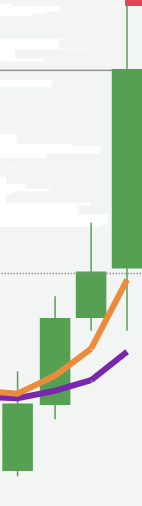
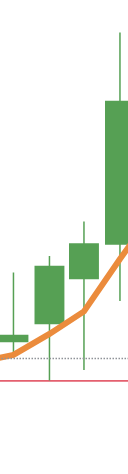
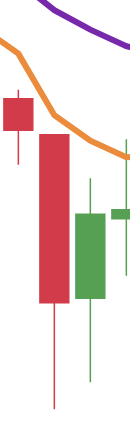
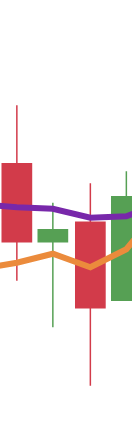
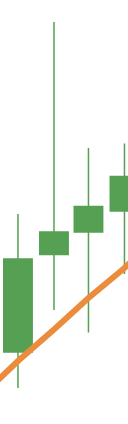
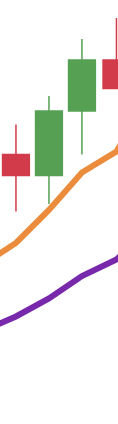
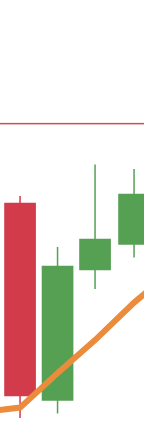
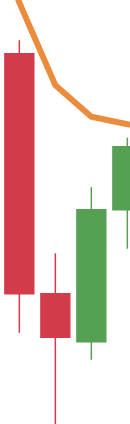
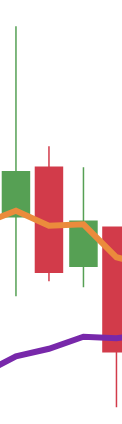
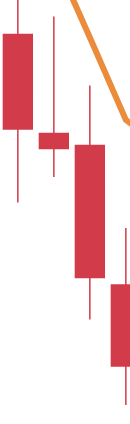
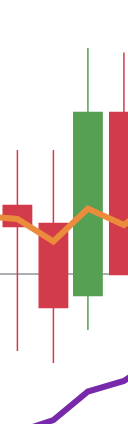
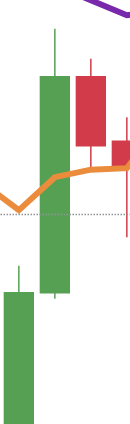
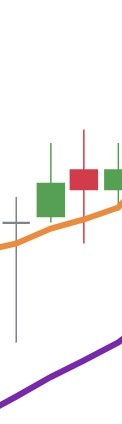
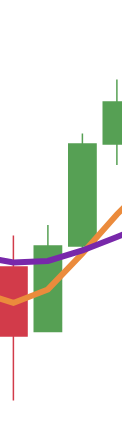
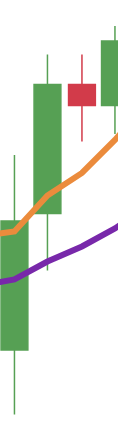
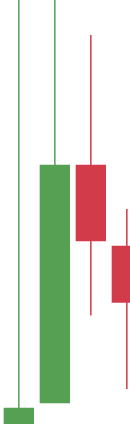
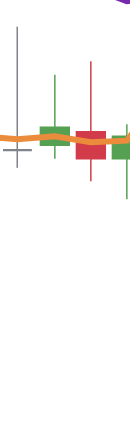
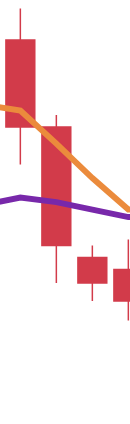
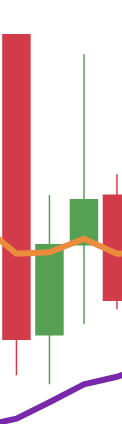
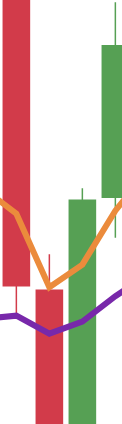
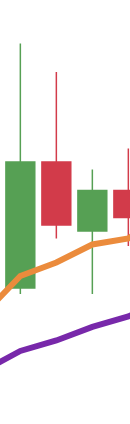
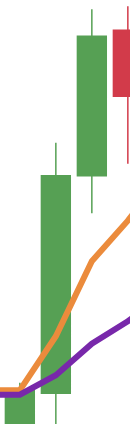
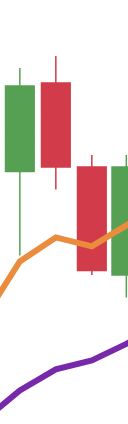

In [30]:
# Display the 3D projections with clickable images
display_projections_2d(tsne_embeddings, labels, files, image_data_uris)